In [ ]:
# Install required packages
!pip install -q transformers
!pip install -q hazm
!pip install -q clean-text[gpl]

In [ ]:
# Import required packages

import numpy as np
import pandas as pd
import random 

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.utils import shuffle

import hazm
from cleantext import clean

import plotly.express as px
import plotly.graph_objects as go

from tqdm.notebook import tqdm

import os
import re
import json
import copy
import collections

### Load the data using Pandas

In [ ]:
train_path=os.path.join(os.path.curdir,"train.json")
eval_path=os.path.join(os.path.curdir,"eval.json")
test_path=os.path.join(os.path.curdir,"test.json")

train_data = []
eval_data = []
test_data = []

train_data.extend(json.load(open(train_path,'r',encoding='utf-8')))
eval_data.extend(json.load(open(eval_path,'r',encoding='utf-8')))
test_data.extend(json.load(open(test_path,'r',encoding='utf-8')))

examples = random.sample(train_data,2)

for ex in examples:
    for x in ex.items():
        print(x[0], ": ", x[1])
    print("___")

title :  ابراز امیدواری مدیر اجرایی رولان گاروس از حضور تنیسورهای مطرح در تورنمنت پاریس
abstract :  مدیر اجرایی مسابقات تنیس آزاد فرانسه ابراز امیدواری کرد تنیسورهای مطرح جهان در این تورنمنت شرکت کنند.
text :  به گزارش خبرگزاری فارس، مدیراجرایی تنیس آزاد فرانسه انتظار دارد بهترین تنیسورهای جهان در این تورنمنت حضور پیدا کنند. مسابقات رولان گاروس قرار است اواخر سپتامبر (اوایل مهر) برگزار شود.
این تاریخ بسیار بحث‌برانگیز بود چرا که به صورت یک جانبه و بدون مشورت با جامعه تنیس زمان آن اعلام شده و 2 هفته بعد از مسابقات آزاد آمریکا برگزار می‌شود.
گای فورگت مدیر اجرایی رولان گاروس در این باره به یورو اسپورت گفت: همان طور که شما می‌دانید، ATP و WTA خیلی سخت با ما و گرنداسلم کار می‌کنند تا بتوانند برنامه‌ای برای پایان فصل بگذارند و ورزشکاران مسابقه دهند.
وی افزود: من دوست دارم همه بازیکنان زن و مرد در این تورنمنت حضور داشته باشند چرا که می‌خواهم لبخند را روی لبان آنها ببینم. هر ساله از اینکه کنار کورت می‌نشینم و مسابقات تنیسورهای سطح بالا را می‌بینم لذت می‌برم.
مدیر اجرایی رولان گاروس درباره حضو

In [ ]:
data = pd.DataFrame()
data['text'] = [x['text'] for x in train_data]
data['category'] = [x['category'] for x in train_data]
data['title'] = [x['title'] for x in train_data]
data['abstract'] = [x['abstract'] for x in train_data]
data['category_id'] = data['category'].factorize()[0]

In [ ]:
valid_df = pd.DataFrame()
valid_df['text'] = [x['text'] for x in eval_data]
valid_df['category'] = [x['category'] for x in eval_data]
valid_df['title'] = [x['title'] for x in eval_data]
valid_df['abstract'] = [x['abstract'] for x in eval_data]
valid_df['category_id'] = valid_df['category'].factorize()[0]

In [ ]:
test_df = pd.DataFrame()
test_df['text'] = [x['text'] for x in test_data]
test_df['category'] = [x['category'] for x in test_data]
test_df['title'] = [x['title'] for x in test_data]
test_df['abstract'] = [x['abstract'] for x in test_data]
test_df['category_id'] = test_df['category'].factorize()[0]

In [ ]:
data.head()

,text,category,title,abstract,category_id
0,به گزارش خبرگزاری فارس، حجت الاسلام والمسلمین ...,politics,چشم طمع دشمن با طنین‌انداز شدن نوای تفکر بسیجی...,رئیس شورای سیاستگذاری ائمه جمعه گفت: اگر در کش...,0
1,به گزارش خبرنگار ورزشی خبرگزاری فارس، مجید جلا...,sports,جلالی: هدایت گل‌گهر یکی از سخت‌ترین پروژه‌های ...,سرمربی تیم فوتبال گل‌گهر گفت: هدایت تیم گل‌گهر...,1
2,به گزارش خبرنگار حوزه قرآن و فعالیت‌های دینی خ...,culture,حضرت معصومه از زبان علما و بزرگان/ توصیه امیرا...,امام صادق(ع) می‌فرماید: برای خدا حرمی است و آن...,2
3,خبرگزاری فارس ـ یادداشت میهمان؛ علیرضا فقیهی‌ر...,politics,جیغ بنفش در برابر دیوار چین,پروپاگاندای تبلیغاتی که بدون هیچ استناد و اطلا...,0
4,به گزارش خبرنگار حوزه مسجد و هیأت خبرگزاری فار...,culture,حدادیان: دافعه حاج منصور و علی انسانی ما را تر...,نشست صمیمی مداحان جوان و شاخص تهران و قم با مس...,2


### Normalization / Preprocessing

The comments have different lengths based on words! Detecting the most normal range could help us find the maximum length of the sequences for the preprocessing step. On the other hand, we suppose that the minimum word combination for having a meaningful phrase for our learning process is 3.

In [ ]:
# calculate the length of comments based on their words
data['news_len_by_words'] = data['text'].apply(lambda t: len(hazm.word_tokenize(t)))

In [ ]:
min_max_len = data["news_len_by_words"].min(), data["news_len_by_words"].max()
print(f'Min: {min_max_len[0]} \tMax: {min_max_len[1]}')

Min: 2 	Max: 14103


In [ ]:
unique_categories = list(sorted(data['category'].unique()))
print(f'We have #{len(unique_categories)}: {unique_categories}')

We have #9: ['arts-media', 'culture', 'economy', 'politics', 'regional-offices', 'scientific-academic', 'social', 'sports', 'world']


In [ ]:
fig = go.Figure()

groupby_rate = data.groupby('category')['category'].count()

fig.add_trace(go.Bar(
    x=list(sorted(groupby_rate.index)),
    y=groupby_rate.tolist(),
    text=groupby_rate.tolist(),
    textposition='auto'
))

fig.update_layout(
    title_text='Distribution of category within news',
    xaxis_title_text='category',
    yaxis_title_text='Frequency',
    bargap=0.2,
    bargroupgap=0.2)

fig.show()

Cleaning is the final step in this section. Our cleaned method includes these steps:

- fixing unicodes
- removing specials like a phone number, email, url, new lines, ...
- cleaning HTMLs
- normalizing
- removing emojis

In [ ]:
def cleanhtml(raw_html):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', raw_html)
    return cleantext


def cleaning(text):
    text = text.strip()
    
    # regular cleaning
    text = clean(text,
        fix_unicode=True,
        to_ascii=False,
        lower=True,
        no_line_breaks=True,
        no_urls=True,
        no_emails=True,
        no_phone_numbers=True,
        no_numbers=False,
        no_digits=False,
        no_currency_symbols=True,
        no_punct=False,
        replace_with_url="",
        replace_with_email="",
        replace_with_phone_number="",
        replace_with_number="",
        replace_with_digit="0",
        replace_with_currency_symbol="",
    )

    # cleaning htmls
    text = cleanhtml(text)
    
    # normalizing
    normalizer = hazm.Normalizer()
    text = normalizer.normalize(text)
    
    # removing wierd patterns
    wierd_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u'\U00010000-\U0010ffff'
        u"\u200d"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\u3030"
        u"\ufe0f"
        u"\u2069"
        u"\u2066"
        # u"\u200c"
        u"\u2068"
        u"\u2067"
        "]+", flags=re.UNICODE)
    
    text = wierd_pattern.sub(r'', text)
    
    # removing extra spaces, hashtags
    text = re.sub("#", "", text)
    text = re.sub("\s+", " ", text)
    
    return text

In [ ]:
# cleaning news
data['cleaned_news'] = data['text'].apply(cleaning)
# calculate the length of news based on their words
data['cleaned_news_len_by_words'] = data['cleaned_news'].apply(lambda t: len(hazm.word_tokenize(t)))


data.head()

,text,category,title,abstract,category_id,news_len_by_words,cleaned_news,cleaned_news_len_by_words
0,به گزارش خبرگزاری فارس، حجت الاسلام والمسلمین ...,politics,چشم طمع دشمن با طنین‌انداز شدن نوای تفکر بسیجی...,رئیس شورای سیاستگذاری ائمه جمعه گفت: اگر در کش...,0,453,به گزارش خبرگزاری فارس، حجت الاسلام والمسلمین ...,445
1,به گزارش خبرنگار ورزشی خبرگزاری فارس، مجید جلا...,sports,جلالی: هدایت گل‌گهر یکی از سخت‌ترین پروژه‌های ...,سرمربی تیم فوتبال گل‌گهر گفت: هدایت تیم گل‌گهر...,1,328,به گزارش خبرنگار ورزشی خبرگزاری فارس، مجید جلا...,329
2,به گزارش خبرنگار حوزه قرآن و فعالیت‌های دینی خ...,culture,حضرت معصومه از زبان علما و بزرگان/ توصیه امیرا...,امام صادق(ع) می‌فرماید: برای خدا حرمی است و آن...,2,1969,به گزارش خبرنگار حوزه قرآن و فعالیت‌های دینی خ...,1966
3,خبرگزاری فارس ـ یادداشت میهمان؛ علیرضا فقیهی‌ر...,politics,جیغ بنفش در برابر دیوار چین,پروپاگاندای تبلیغاتی که بدون هیچ استناد و اطلا...,0,1392,خبرگزاری فارس یادداشت میهمان؛ علیرضا فقیهی‌راد...,1358
4,به گزارش خبرنگار حوزه مسجد و هیأت خبرگزاری فار...,culture,حدادیان: دافعه حاج منصور و علی انسانی ما را تر...,نشست صمیمی مداحان جوان و شاخص تهران و قم با مس...,2,1392,به گزارش خبرنگار حوزه مسجد و هیأت خبرگزاری فار...,1387


In [ ]:
data = data[['text', 'category','category_id']]
data.columns = ['text', 'category','category_id']
data.head()

,text,category,category_id
0,به گزارش خبرگزاری فارس، حجت الاسلام والمسلمین ...,politics,0
1,به گزارش خبرنگار ورزشی خبرگزاری فارس، مجید جلا...,sports,1
2,به گزارش خبرنگار حوزه قرآن و فعالیت‌های دینی خ...,culture,2
3,خبرگزاری فارس ـ یادداشت میهمان؛ علیرضا فقیهی‌ر...,politics,0
4,به گزارش خبرنگار حوزه مسجد و هیأت خبرگزاری فار...,culture,2


In [ ]:
train_categories=[item['category'] for item in train_data]
categories=np.unique(train_categories)

In [ ]:
print(f'We have #{len(categories)} categories: {categories}')

We have #9 categories: ['arts-media' 'culture' 'economy' 'politics' 'regional-offices'
 'scientific-academic' 'social' 'sports' 'world']


In [ ]:
x_train, y_train = data['text'].values.tolist(), data['category_id'].values.tolist()
x_valid, y_valid = valid_df['text'].values.tolist(), valid_df['category_id'].values.tolist()
x_test, y_test = test_df['text'].values.tolist(), test_df['category_id'].values.tolist()




![BERT INPUTS](https://res.cloudinary.com/m3hrdadfi/image/upload/v1595158991/kaggle/bert_inputs_w8rith.png)

The BERT model input is a combination of 3 embeddings.
- Token embeddings: WordPiece token vocabulary (WordPiece is another word segmentation algorithm, similar to BPE)
- Segment embeddings: for pair sentences [A-B] marked as $E_A$ or $E_B$ mean that it belongs to the first sentence or the second one.
- Position embeddings: specify the position of words in a sentence

## TensorFlow

In [ ]:
!pip install transformers
!pip install tensorflow

In [ ]:
from transformers import BertConfig, BertTokenizer
from transformers import TFBertModel, TFBertForSequenceClassification
from transformers import glue_convert_examples_to_features

import tensorflow as tf

### Configuration

In [ ]:
# general config
MAX_LEN = 128
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
TEST_BATCH_SIZE = 16

EPOCHS = 5
EEVERY_EPOCH = 1000
LEARNING_RATE = 2e-5
CLIP = 0.0

MODEL_NAME_OR_PATH = 'HooshvareLab/bert-fa-base-uncased'
OUTPUT_PATH = './models/tf_model.bin'

os.makedirs(os.path.dirname(OUTPUT_PATH), exist_ok=True)

In [ ]:
label2id = {label: i for i, label in enumerate(categories)}
id2label = {v: k for k, v in label2id.items()}

print(f'label2id: {label2id}')
print(f'id2label: {id2label}')

label2id: {'arts-media': 0, 'culture': 1, 'economy': 2, 'politics': 3, 'regional-offices': 4, 'scientific-academic': 5, 'social': 6, 'sports': 7, 'world': 8}
id2label: {0: 'arts-media', 1: 'culture', 2: 'economy', 3: 'politics', 4: 'regional-offices', 5: 'scientific-academic', 6: 'social', 7: 'sports', 8: 'world'}


In [ ]:
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME_OR_PATH)
config = BertConfig.from_pretrained(
    MODEL_NAME_OR_PATH, **{
        'label2id': label2id,
        'id2label': id2label,
    })

print(config.to_json_string())

Downloading:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440 [00:00<?, ?B/s]

{
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "arts-media",
    "1": "culture",
    "2": "economy",
    "3": "politics",
    "4": "regional-offices",
    "5": "scientific-academic",
    "6": "social",
    "7": "sports",
    "8": "world"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "arts-media": 0,
    "culture": 1,
    "economy": 2,
    "politics": 3,
    "regional-offices": 4,
    "scientific-academic": 5,
    "social": 6,
    "sports": 7,
    "world": 8
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.15.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 100000
}



### Input Embeddings / Dataset

In [ ]:
class InputExample:
    """ A single example for simple sequence classification. """

    def __init__(self, guid, text_a, text_b=None, label=None):
        """ Constructs a InputExample. """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label


def make_examples(tokenizer, x, y=None, maxlen=128, output_mode="classification", is_tf_dataset=True):
    examples = []
    y = y if isinstance(y, list) or isinstance(y, np.ndarray) else [None] * len(x)

    for i, (_x, _y) in tqdm(enumerate(zip(x, y)), position=0, total=len(x)):
        guid = "%s" % i
        label = int(_y)
        
        if isinstance(_x, str):
            text_a = _x
            text_b = None
        else:
            assert len(_x) == 2
            text_a = _x[0]
            text_b = _x[1]
        
        examples.append(InputExample(guid=guid, text_a=text_a, text_b=text_b, label=label))
    
    features = glue_convert_examples_to_features(
        examples, 
        tokenizer, 
        maxlen, 
        output_mode=output_mode, 
        label_list=list(np.unique(y)))

    all_input_ids = []
    all_attention_masks = []
    all_token_type_ids = []
    all_labels = []

    for f in tqdm(features, position=0, total=len(examples)):
        if is_tf_dataset:
            all_input_ids.append(tf.constant(f.input_ids))
            all_attention_masks.append(tf.constant(f.attention_mask))
            all_token_type_ids.append(tf.constant(f.token_type_ids))
            all_labels.append(tf.constant(f.label))
        else:
            all_input_ids.append(f.input_ids)
            all_attention_masks.append(f.attention_mask)
            all_token_type_ids.append(f.token_type_ids)
            all_labels.append(f.label)

    if is_tf_dataset:
        dataset = tf.data.Dataset.from_tensor_slices(({
            'input_ids': all_input_ids,
            'attention_mask': all_attention_masks,
            'token_type_ids': all_token_type_ids
        }, all_labels))

        return dataset, features
    
    xdata = [np.array(all_input_ids), np.array(all_attention_masks), np.array(all_token_type_ids)]
    ydata = all_labels

    return [xdata, ydata], features

In [ ]:
train_dataset_base, train_examples = make_examples(tokenizer, x_train, y_train, maxlen=128)
valid_dataset_base, valid_examples = make_examples(tokenizer, x_valid, y_valid, maxlen=128)

test_dataset_base, test_examples = make_examples(tokenizer, x_test, y_test, maxlen=128)
[xtest, ytest], test_examples = make_examples(tokenizer, x_test, y_test, maxlen=128, is_tf_dataset=False)

  0%|          | 0/2000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/data/processors/glue.py:67: FutureWarning:

This function will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/pytorch/text-classification/run_glue.py



  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [ ]:
for value in train_dataset_base.take(1):
    print(f'     input_ids: {value[0]["input_ids"]}')
    print(f'attention_mask: {value[0]["attention_mask"]}')
    print(f'token_type_ids: {value[0]["token_type_ids"]}')
    print(f'        target: {value[1]}')

In [ ]:
def get_training_dataset(dataset, batch_size):
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size)

    return dataset

def get_validation_dataset(dataset, batch_size):
    dataset = dataset.batch(batch_size)

    return dataset

In [ ]:
train_dataset = get_training_dataset(train_dataset_base, TRAIN_BATCH_SIZE)
valid_dataset = get_training_dataset(valid_dataset_base, VALID_BATCH_SIZE)

train_steps = len(train_examples) // TRAIN_BATCH_SIZE
valid_steps = len(valid_examples) // VALID_BATCH_SIZE

train_steps, valid_steps

### Model

In [ ]:
def build_model(model_name, config, learning_rate=3e-5):
    model = TFBertForSequenceClassification.from_pretrained(model_name, config=config)

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
    model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

    return model

In [ ]:
model = build_model(MODEL_NAME_OR_PATH, config, learning_rate=LEARNING_RATE)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/bert-fa-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Training

In [ ]:
%%time

r = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    epochs=EPOCHS,
    verbose=1)

final_accuracy = r.history['val_accuracy']
print('FINAL ACCURACY MEAN: ', np.mean(final_accuracy))

In [ ]:
# save the model

model.save_pretrained(os.path.dirname('./models/tf_model1.bin'))

### Evaluation / Prediction

In [ ]:
predictions[0]

array([[    2,  6000,  4922, ...,     0,     0,     0],
       [    2,  2789,  3361, ..., 53913,  3948,     4],
       [    2,  3434,  3780, ...,  3332,  3363,     4],
       ...,
       [    2,  2789,  3361, ...,  2791,  3958,     4],
       [    2,  7336,  5838, ...,  5864,  6937,     4],
       [    2,  2789,  3361, ..., 69766,  2820,     4]])

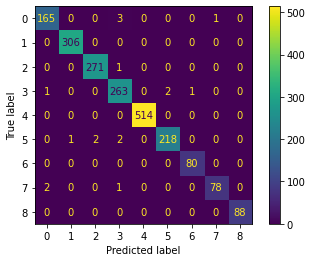

[0, 1, 2, 3, 1, 4, 4, 0, 4, 4, 4, 5, 5, 3, 3, 0, 4, 4, 2, 1, 4, 2, 6, 7, 2, 4, 7, 4, 0, 6, 4, 7, 5, 0, 3, 2, 3, 7, 3, 5, 5, 4, 4, 4, 4, 2, 4, 1, 5, 4, 3, 2, 3, 1, 2, 1, 2, 7, 4, 4, 4, 5, 1, 8, 5, 4, 1, 4, 4, 7, 2, 2, 0, 2, 2, 1, 5, 2, 4, 4, 7, 5, 4, 4, 4, 5, 6, 6, 2, 3, 3, 2, 4, 2, 6, 5, 1, 7, 5, 5, 1, 1, 1, 1, 5, 3, 1, 2, 3, 4, 5, 6, 1, 4, 1, 1, 4, 5, 7, 3, 6, 4, 5, 5, 7, 3, 1, 1, 3, 5, 2, 1, 0, 6, 4, 1, 1, 4, 3, 5, 1, 4, 4, 4, 4, 2, 1, 4, 4, 4, 3, 1, 4, 6, 3, 4, 2, 3, 2, 1, 4, 5, 4, 4, 8, 3, 4, 8, 5, 0, 4, 3, 4, 2, 3, 1, 4, 2, 7, 4, 4, 1, 1, 3, 1, 5, 5, 5, 2, 1, 1, 1, 2, 2, 4, 6, 4, 1, 1, 0, 2, 4, 4, 0, 5, 0, 8, 1, 4, 2, 5, 5, 3, 4, 1, 4, 8, 4, 4, 5, 4, 1, 2, 4, 5, 6, 2, 8, 3, 3, 0, 3, 0, 4, 3, 2, 2, 5, 1, 3, 4, 4, 4, 6, 4, 3, 8, 4, 4, 3, 1, 3, 4, 6, 5, 6, 1, 4, 0, 2, 2, 6, 7, 0, 4, 3, 4, 1, 5, 8, 4, 2, 1, 3, 1, 8, 3, 5, 1, 3, 1, 2, 2, 4, 4, 4, 7, 5, 6, 4, 1, 1, 4, 1, 4, 4, 0, 7, 0, 5, 3, 2, 3, 1, 4, 7, 0, 6, 8, 2, 2, 3, 3, 5, 0, 8, 4, 4, 0, 4, 0, 1, 4, 5, 2, 4, 0, 1, 4, 6, 5, 1, 4, 

In [ ]:
# ev = model.evaluate(test_dataset_base.batch(TEST_BATCH_SIZE))
# print()
# print(f'Evaluation: {ev}')
# print()

predictions = model.predict(xtest)
ypred = predictions[0].argmax(axis=-1).tolist()
print(ypred)
mapping = {
    2:0,
    5:1,
    7:2,
    0:3,
    1:4,
    6:5,
    8:7,
    5:6,
    3:8

}
ypred = [mapping[x] for x in ypred]

print(ytest)
print()
print(classification_report(ytest, ypred, target_names=categories))
print()

print(f'F1: {f1_score(ytest, ypred, average="weighted")}')